# Data Simulations

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of AI for Health (AIH), Talavera-López Lab
- **Date of Creation:** 24.05.2024
- **Date of Last Modification:** 24.05.2024

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                generate_enriched_gp_info_plots)

/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/urllib3/connectionpool.py", line 715, in urlopen
    httplib_response = self._make_request(
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/urllib3/connectionpool.py", line 404, in _make_request
    self._validate_conn(conn)
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/urllib3/connectionpool.py", line 1058, in _validate_conn
    conn.connect()
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/urlli

### 2.1 Create Prior Knowledge Gene Program (GP) Mask

- NicheCompass expects a prior GP mask as input, which it will use to make its latent feature space interpretable (through linear masked decoders). 
- The user can provide a custom GP mask to NicheCompass based on the biological question of interest.
- As a default, here we create a GP mask based on three databases of prior knowledge of inter- and intracellular interaction pathways:
    - OmniPath (Ligand-Receptor GPs)
    - MEBOCOST (Enzyme-Sensor GPs)
    - NicheNet (Combined Interaction GPs)

In [3]:
species = "mouse"

ga_data_folder_path = "../datasets/ga_data"
gp_data_folder_path = "../datasets/gp_data"
so_data_folder_path = "../datasets/srt_data"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
collectri_tf_network_file_path = f"{gp_data_folder_path}/collectri_tf_network_{species}.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"

In [4]:
cell_types = [f"Celltype{n}" for n in range(1,5)]
fold_changes = [1, 3, 5, 10]
fold_changes_probs = [0.7, 0.1, 0.1, 0.1]

# Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    min_curation_effort=0,
    load_from_disk=True,
    save_to_disk=False,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=False)

omnipath_gp_df = pd.DataFrame(omnipath_gp_dict.values())

omnipath_gp_df["celltypeA"] = np.random.choice(cell_types, size=len(omnipath_gp_df))
omnipath_gp_df["celltypeB"] = np.random.choice(cell_types, size=len(omnipath_gp_df))
omnipath_gp_df["sources"] = omnipath_gp_df["sources"].apply(lambda x: ",".join(map(str, x)))
omnipath_gp_df["targets"] = omnipath_gp_df["targets"].apply(lambda x: ",".join(map(str, x)))
omnipath_gp_df["fold_change"] = np.random.choice(fold_changes, size=len(omnipath_gp_df), p=fold_changes_probs)
omnipath_gp_df.drop(["sources_categories", "targets_categories"], axis=1, inplace=True)
omnipath_gp_df.to_csv(f"{gp_data_folder_path}/simulations/omnipath_lr_simulations.csv", index=False)

In [6]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=False)

mebocost_gp_df = pd.DataFrame(mebocost_gp_dict.values())

mebocost_gp_df["celltypeA"] = np.random.choice(cell_types, size=len(mebocost_gp_df))
mebocost_gp_df["celltypeB"] = np.random.choice(cell_types, size=len(mebocost_gp_df))
mebocost_gp_df["sources"] = mebocost_gp_df["sources"].apply(lambda x: np.random.choice(x, size=min(10, len(x)), replace=False)) # only keep 10 source genes
mebocost_gp_df["targets"] = mebocost_gp_df["targets"].apply(lambda x: np.random.choice(x, size=min(10, len(x)), replace=False)) # only keep 10 target genes
mebocost_gp_df["sources"] = mebocost_gp_df["sources"].apply(lambda x: ",".join(map(str, x)))
mebocost_gp_df["targets"] = mebocost_gp_df["targets"].apply(lambda x: ",".join(map(str, x)))
mebocost_gp_df["fold_change"] = np.random.choice(fold_changes, size=len(mebocost_gp_df), p=fold_changes_probs)
mebocost_gp_df.drop(["sources_categories", "targets_categories"], axis=1, inplace=True)
mebocost_gp_df.to_csv(f"{gp_data_folder_path}/simulations/mebocost_es_simulations.csv", index=False)

In [8]:
# Retrieve NicheNet GPs (source: ligand genes; target: receptor genes, target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=True,
    save_to_disk=False,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=False)

nichenet_gp_df = pd.DataFrame(nichenet_gp_dict.values())

nichenet_gp_df["celltypeA"] = np.random.choice(cell_types, size=len(nichenet_gp_df))
nichenet_gp_df["celltypeB"] = np.random.choice(cell_types, size=len(nichenet_gp_df))
nichenet_gp_df["targets"] = nichenet_gp_df["targets"].apply(lambda x: np.random.choice(x, size=min(10, len(x)), replace=False)) # only keep 10 target genes
nichenet_gp_df["sources"] = nichenet_gp_df["sources"].apply(lambda x: ",".join(map(str, x)))
nichenet_gp_df["targets"] = nichenet_gp_df["targets"].apply(lambda x: ",".join(map(str, x)))
nichenet_gp_df["fold_change"] = np.random.choice(fold_changes, size=len(nichenet_gp_df), p=fold_changes_probs)
nichenet_gp_df.drop(["sources_categories", "targets_categories"], axis=1, inplace=True)
nichenet_gp_df.to_csv(f"{gp_data_folder_path}/simulations/nichenet_lrt_simulations.csv", index=False)

/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/nichecompass/utils/gene_programs.py:496: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ligand_target_matrix_df.applymap(


In [ ]:
adata_free = sc.read_h5ad("./simulated_free_1.h5ad")
adata_free.obsm["spatial"] = adata_free.obs[["x", "y"]].values

In [11]:
adata_ref = sc.read_h5ad(f"{so_data_folder_path}/simulations/simulated_ref_omnipath.h5ad")
adata_ref.obsm["spatial"] = adata_ref.obs[["x", "y"]].values

In [12]:
# Visualize cell types in tissue
sq.pl.spatial_scatter(adata_free, color="cell_type", shape=None) 

NameError: name 'adata_free' is not defined

In [13]:
# Visualize cell types in tissue
sq.pl.spatial_scatter(adata_free, color="region_label", shape=None) 

NameError: name 'adata_free' is not defined

In [ ]:
adata_free.uns

In [ ]:
sq.pl.spatial_scatter(adata_free, color="EFNA1", shape=None) 

In [ ]:
sq.pl.spatial_scatter(adata_free, color="EPHA1", shape=None) 

/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


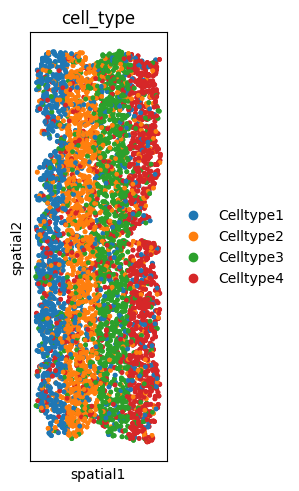

In [14]:
# Visualize cell types in tissue
sq.pl.spatial_scatter(adata_ref, color="cell_type", shape=None) 

/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/aih/sebastian.birk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


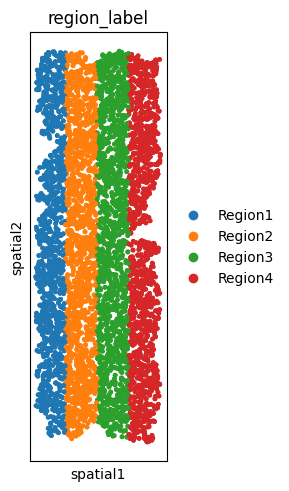

In [15]:
# Visualize cell types in tissue
sq.pl.spatial_scatter(adata_ref, color="region_label", shape=None) 

In [16]:
adata_ref.uns

{'X_name': 'counts',
 'gp_data':      sources targets  celltypeA  celltypeB  fold_change
 0       Bdnf    Drd4  Celltype1  Celltype1         10.0
 1       Epor   Stat3  Celltype1  Celltype1          3.0
 2        Fyn   Mapk7  Celltype1  Celltype1          1.0
 3        Avp    Aqp2  Celltype2  Celltype4          3.0
 4        Ngf   Smpd2  Celltype1  Celltype4          1.0
 ..       ...     ...        ...        ...          ...
 895   Gpr15l   Gpr15  Celltype4  Celltype2          1.0
 896    Clul1   Gpr55  Celltype1  Celltype3          1.0
 897   Mansc1   Gpr55  Celltype4  Celltype2          1.0
 898     Msmb   Gpr55  Celltype2  Celltype4          3.0
 899  Spag11b   Gpr55  Celltype4  Celltype2          1.0
 
 [900 rows x 5 columns],
 'cell_type_colors': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
 'region_label_colors': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']}

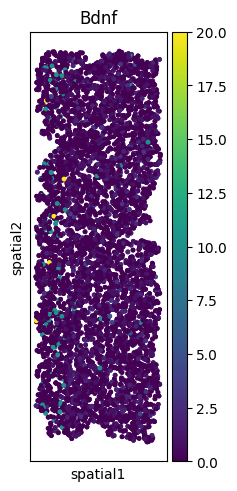

In [17]:
sq.pl.spatial_scatter(adata_ref, color="Bdnf", shape=None) 

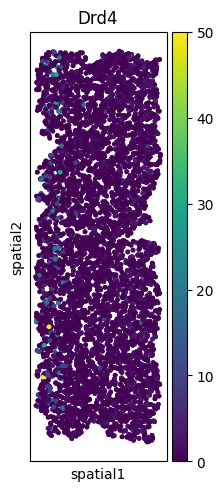

In [18]:
sq.pl.spatial_scatter(adata_ref, color="Drd4", shape=None) 

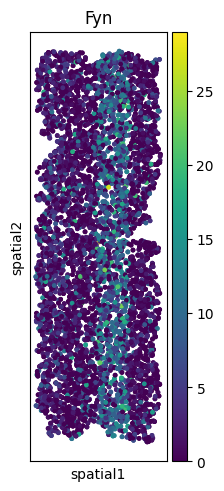

In [19]:
sq.pl.spatial_scatter(adata_ref, color="Fyn", shape=None) 

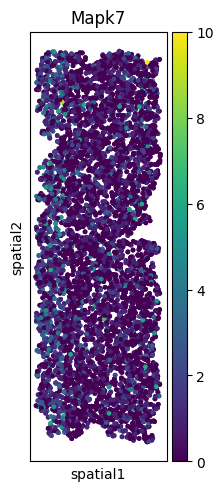

In [20]:
sq.pl.spatial_scatter(adata_ref, color="Mapk7", shape=None) 